In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import pandas as pd
import re

# Pre-process mutation data

### Import TRACERx 

In [2]:
data_dir = "/data/morrisq/huangf2/project/mutLLM/data/tracerx_snv_96.csv"
df = pd.read_csv(data_dir, index_col=0)
print(df.shape)
df.head()

(659339, 18)


,Unnamed: 0,CASE_ID,SAMPLE,CHR,POS,TRI_NT_CONTEXT,histology_3,histology_full,anatomical_site_label,original_anatomical_site_label,sample_type,DEPTH,COPY_NUMBER_A,COPY_NUMBER_B,ACF,PLOIDY,REF,VAR
0,0,CRUK0719,CRUK0719_BR_T1.R1,9,16434926,TCGA,Other,Large cell carcinoma,metachronousMet_BR_T1,metachronousMet_BR_T1.R1,metastasis,913,8,0,0.24,4.05,TCA,G
1,1,CRUK0719,CRUK0719_BR_T1.R2,9,16434926,TCGA,Other,Large cell carcinoma,metachronousMet_BR_T1,metachronousMet_BR_T1.R2,metastasis,1006,9,0,0.53,4.05,TCA,G
2,2,CRUK0719,CRUK0719_SU_T1.R1,9,16434926,TCGA,Other,Large cell carcinoma,primary_SU_T1,primary_SU_T1.R1,primary,847,9,0,0.13,5.15,TCA,G
3,3,CRUK0719,CRUK0719_SU_T1.R2,9,16434926,TCGA,Other,Large cell carcinoma,primary_SU_T1,primary_SU_T1.R2,primary,801,8,0,0.11,4.40,TCA,G
4,4,CRUK0719,CRUK0719_SU_T1.R3,9,16434926,TCGA,Other,Large cell carcinoma,primary_SU_T1,primary_SU_T1.R3,primary,694,9,0,0.13,4.85,TCA,G


### Import IMPACT

In [3]:
impact_dir = '/data/morrisq/huangf2/project/mutLLM/data/impact_snv_augmented.csv'
df_impact = pd.read_csv(impact_dir, header=0)
print(df_impact.shape)
df_impact.head()

(2521939, 14)


,id,patient,tumor,chr,pos,mutation,ref,var,bias,strandedness,version,Sample Type,Cancer Type,Cancer Type Detailed
0,P-0000004-T01-IM3,4,1,1,16265904,TTAG,TTG,A,U,1,3,Primary,Breast Cancer,Breast Invasive Ductal Carcinoma
1,P-0000004-T01-IM3,4,1,1,16265908,ATAG,ATG,A,T,-1,3,Primary,Breast Cancer,Breast Invasive Ductal Carcinoma
2,P-0000004-T01-IM3,4,1,4,1801219,GCTG,GCG,T,U,1,3,Primary,Breast Cancer,Breast Invasive Ductal Carcinoma
3,P-0000004-T01-IM3,4,1,4,1801542,CTCA,CTA,C,T,-1,3,Primary,Breast Cancer,Breast Invasive Ductal Carcinoma
4,P-0000004-T01-IM3,4,1,4,1803704,ATCG,ATG,C,U,1,3,Primary,Breast Cancer,Breast Invasive Ductal Carcinoma


### Process position bins

In [4]:
bin_size = 1000000
df['CHR'] = df['CHR'].astype(int)
df['POS'] = df['POS'] // bin_size
chr_bins = round(df.groupby('CHR')['POS'].max()).to_list()

bins = {}
for i in range(1, 24):
    bins[i] = 0
for i in range(2, 24):
    bins[i] += bins[i-1] + int(chr_bins[i-2])
bins

{1: 0,
 2: 249,
 3: 491,
 4: 688,
 5: 878,
 6: 1058,
 7: 1228,
 8: 1386,
 9: 1532,
 10: 1673,
 11: 1808,
 12: 1942,
 13: 2075,
 14: 2190,
 15: 2297,
 16: 2399,
 17: 2489,
 18: 2570,
 19: 2647,
 20: 2706,
 21: 2768,
 22: 2816,
 23: 2867}

In [5]:
df['BIN'] = df['CHR'].map(bins) + df['POS']

### Impact NSCLC cohort

In [6]:
df_impact_nsclc = df_impact[df_impact['Cancer Type'] == 'Non-Small Cell Lung Cancer']
df_impact_nsclc = df_impact_nsclc[~df_impact_nsclc['chr'].isin(['X', 'Y'])]

df_impact_nsclc['bin'] = df_impact_nsclc['chr'].astype(int).map(bins) + df_impact_nsclc['pos'] // bin_size

df_impact_nsclc.shape

(358828, 15)

In [7]:
df_impact_nsclc.head()

,id,patient,tumor,chr,pos,mutation,ref,var,bias,strandedness,version,Sample Type,Cancer Type,Cancer Type Detailed,bin
21,P-0000012-T03-IM3,12,3,1,46521514,TCGA,TCA,G,U,-1,3,Metastasis,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,46
22,P-0000012-T03-IM3,12,3,1,162740271,TCTC,TCC,T,U,1,3,Metastasis,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,162
23,P-0000012-T03-IM3,12,3,2,16081060,CTAA,CTA,A,T,-1,3,Metastasis,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,265
24,P-0000012-T03-IM3,12,3,3,134977903,CCTT,CCT,T,U,1,3,Metastasis,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,625
25,P-0000012-T03-IM3,12,3,3,138667572,CCGA,CCA,G,U,1,3,Metastasis,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,629


# Construct tensor of mutations

In [8]:
sample_name = 'SAMPLE'
mutation_name = 'TRI_NT_CONTEXT'
bin_name = 'BIN'

unique_sample, counts_sample = np.unique(df[sample_name], return_counts=True)
unique_mut, counts_mut = np.unique(df[mutation_name], return_counts=True)
unique_bin, counts_bin = np.unique(df[bin_name], return_counts=True)

# build sample x mutation x bin tensor
tensor = np.zeros((len(unique_sample), len(unique_mut), max(unique_bin)))

In [9]:
map_sample = {sample: i for i, sample in enumerate(unique_sample)}
map_mut = {mut: i for i, mut in enumerate(unique_mut)}
map_bin = {bin: i for i, bin in enumerate(unique_bin)}

for i, row in df.iterrows():
    tensor[map_sample[row[sample_name]], map_mut[row[mutation_name]], map_bin[row[bin_name]]] += 1
    if i % 100000 == 0:
        print(i)

tensor.shape

0
100000
200000
300000
400000
500000
600000


(690, 96, 2867)

In [10]:
df.head()

,Unnamed: 0,CASE_ID,SAMPLE,CHR,POS,TRI_NT_CONTEXT,histology_3,histology_full,anatomical_site_label,original_anatomical_site_label,sample_type,DEPTH,COPY_NUMBER_A,COPY_NUMBER_B,ACF,PLOIDY,REF,VAR,BIN
0,0,CRUK0719,CRUK0719_BR_T1.R1,9,16,TCGA,Other,Large cell carcinoma,metachronousMet_BR_T1,metachronousMet_BR_T1.R1,metastasis,913,8,0,0.24,4.05,TCA,G,1548
1,1,CRUK0719,CRUK0719_BR_T1.R2,9,16,TCGA,Other,Large cell carcinoma,metachronousMet_BR_T1,metachronousMet_BR_T1.R2,metastasis,1006,9,0,0.53,4.05,TCA,G,1548
2,2,CRUK0719,CRUK0719_SU_T1.R1,9,16,TCGA,Other,Large cell carcinoma,primary_SU_T1,primary_SU_T1.R1,primary,847,9,0,0.13,5.15,TCA,G,1548
3,3,CRUK0719,CRUK0719_SU_T1.R2,9,16,TCGA,Other,Large cell carcinoma,primary_SU_T1,primary_SU_T1.R2,primary,801,8,0,0.11,4.40,TCA,G,1548
4,4,CRUK0719,CRUK0719_SU_T1.R3,9,16,TCGA,Other,Large cell carcinoma,primary_SU_T1,primary_SU_T1.R3,primary,694,9,0,0.13,4.85,TCA,G,1548


In [11]:
map_sample_hist = {}
map_sample_site = {}
for i, sample in enumerate(unique_sample):
    map_sample_hist[sample] = df[df['SAMPLE'] == sample]['histology_full'].unique()[0]
    map_sample_site[sample] = df[df['SAMPLE'] == sample]['anatomical_site_label'].unique()[0]

In [12]:
sample_arr = np.array(list(map_sample.keys()))
mut_arr = np.array(list(map_mut.keys()))
bin_arr = np.arange(max(unique_bin))

In [13]:
sample_name = 'id'
mutation_name = 'mutation'
bin_name = 'bin'

unique_sample_impact, counts_sample = np.unique(df_impact_nsclc[sample_name], return_counts=True)
unique_mut_impact, counts_mut_impact = np.unique(df_impact_nsclc[mutation_name], return_counts=True)
unique_bin_impact, counts_bin_impact = np.unique(df_impact_nsclc[bin_name], return_counts=True)

# build sample x mutation x bin tensor
tensor_impact = np.zeros((len(unique_sample_impact), len(unique_mut_impact), max(unique_bin)))

map_sample_impact = {sample: i for i, sample in enumerate(unique_sample_impact)}
map_mut_impact = {mut: i for i, mut in enumerate(unique_mut_impact)}
map_bin_impact = {bin: i for i, bin in enumerate(unique_bin_impact)}

for i, row in df_impact_nsclc.iterrows():
    tensor_impact[map_sample_impact[row[sample_name]], map_mut_impact[row[mutation_name]], map_bin_impact[row[bin_name]]] += 1
    if i % 100000 == 0:
        print(i)

tensor_impact.shape

1700000
2000000
2300000


(9360, 96, 2867)

# Matrix decomposition

## Data preprocessing

In [14]:
from sklearn.decomposition import NMF

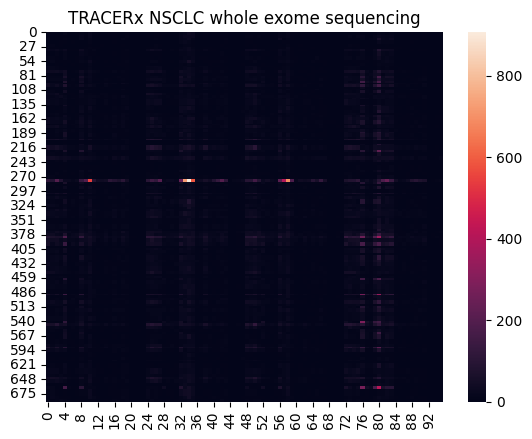

In [15]:
mtx = np.sum(tensor, axis=2)
mtx_impact = np.sum(tensor_impact, axis=2)

ax1 = sns.heatmap(mtx,
                  )
ax1.set_title('TRACERx NSCLC whole exome sequencing')
plt.show()

In [16]:
np.argmax(mtx, axis=0)

array([275, 275, 275, 275, 381, 231, 381, 381, 275, 275, 275, 275, 275,
       275, 275, 275, 275, 275, 275, 275, 381, 275, 231, 275, 381, 275,
       275, 275, 381, 275, 381, 381, 275, 275, 275, 275, 275, 275, 212,
       275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275, 275,
       381, 275, 381, 231, 275, 275, 275, 275, 381, 275, 275, 275, 275,
       275, 275, 275, 231, 164, 381, 371, 381, 381, 381, 275, 539, 489,
       381, 381, 661, 275, 275, 275, 275, 199, 275, 275, 275, 275, 275,
       275, 123, 275, 381, 275])

remove the outlier cluster 275-280. 

Notice the relative abundance of 
- T[C>G]X, T[C>A]X mutations:SBS13/SBS2
- X[C>A]X          mutations:SBS4

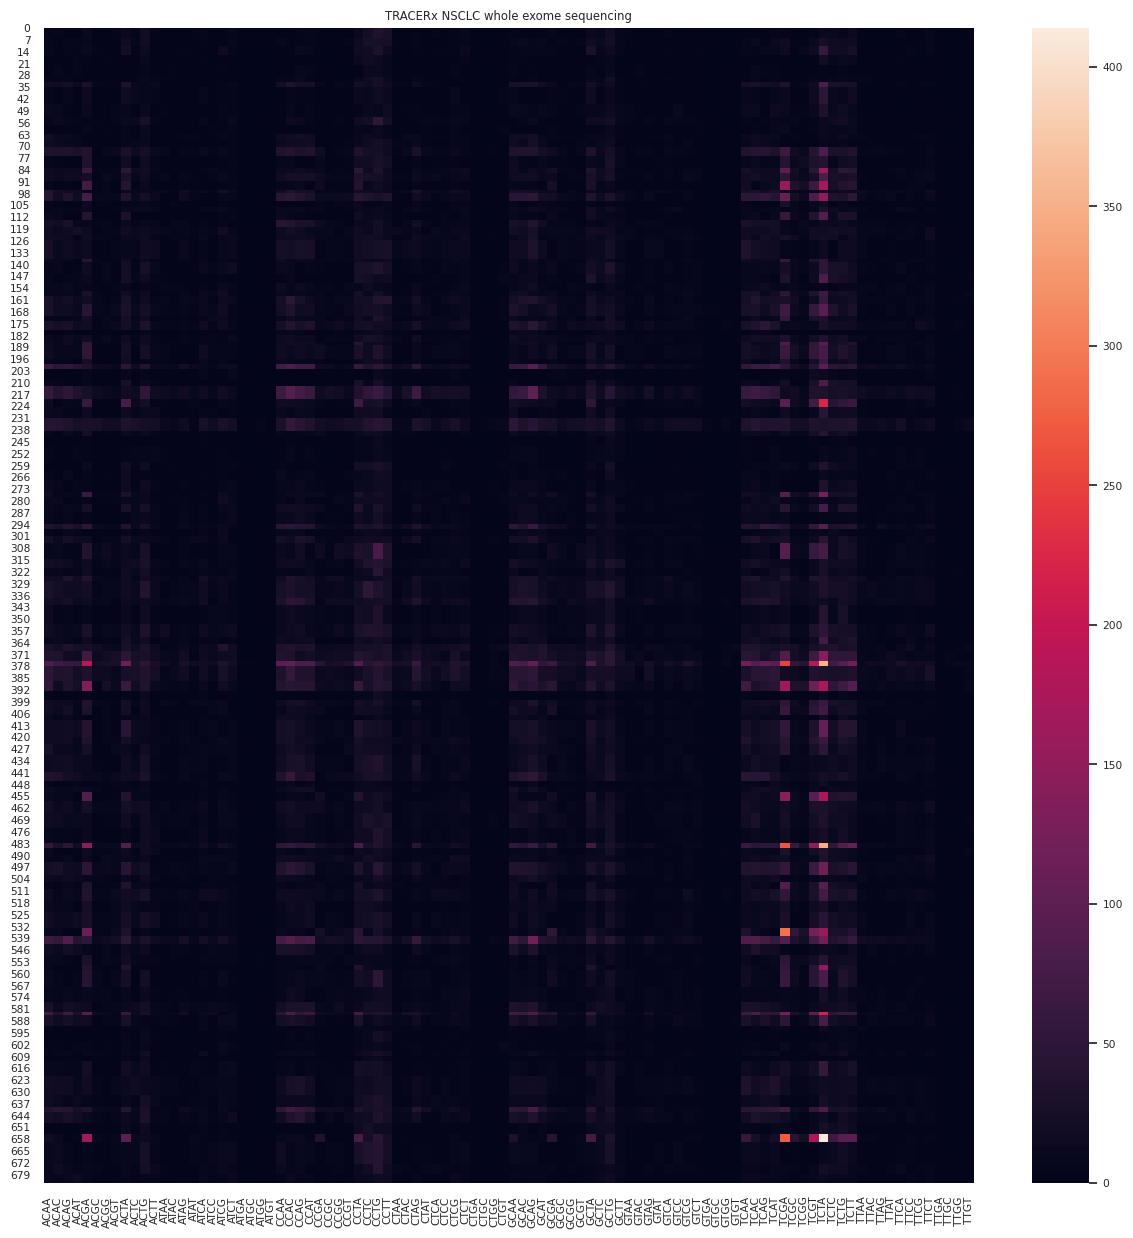

In [17]:
mtx_clean = np.delete(mtx, [275, 276, 277, 278, 279, 280], 0)

sns.set(font_scale=0.7)
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(mtx_clean,
                #   yticklabels=list(map_sample_hist.values())
                  xticklabels=unique_mut,
                  )
ax.set_title('TRACERx NSCLC whole exome sequencing')
plt.show()

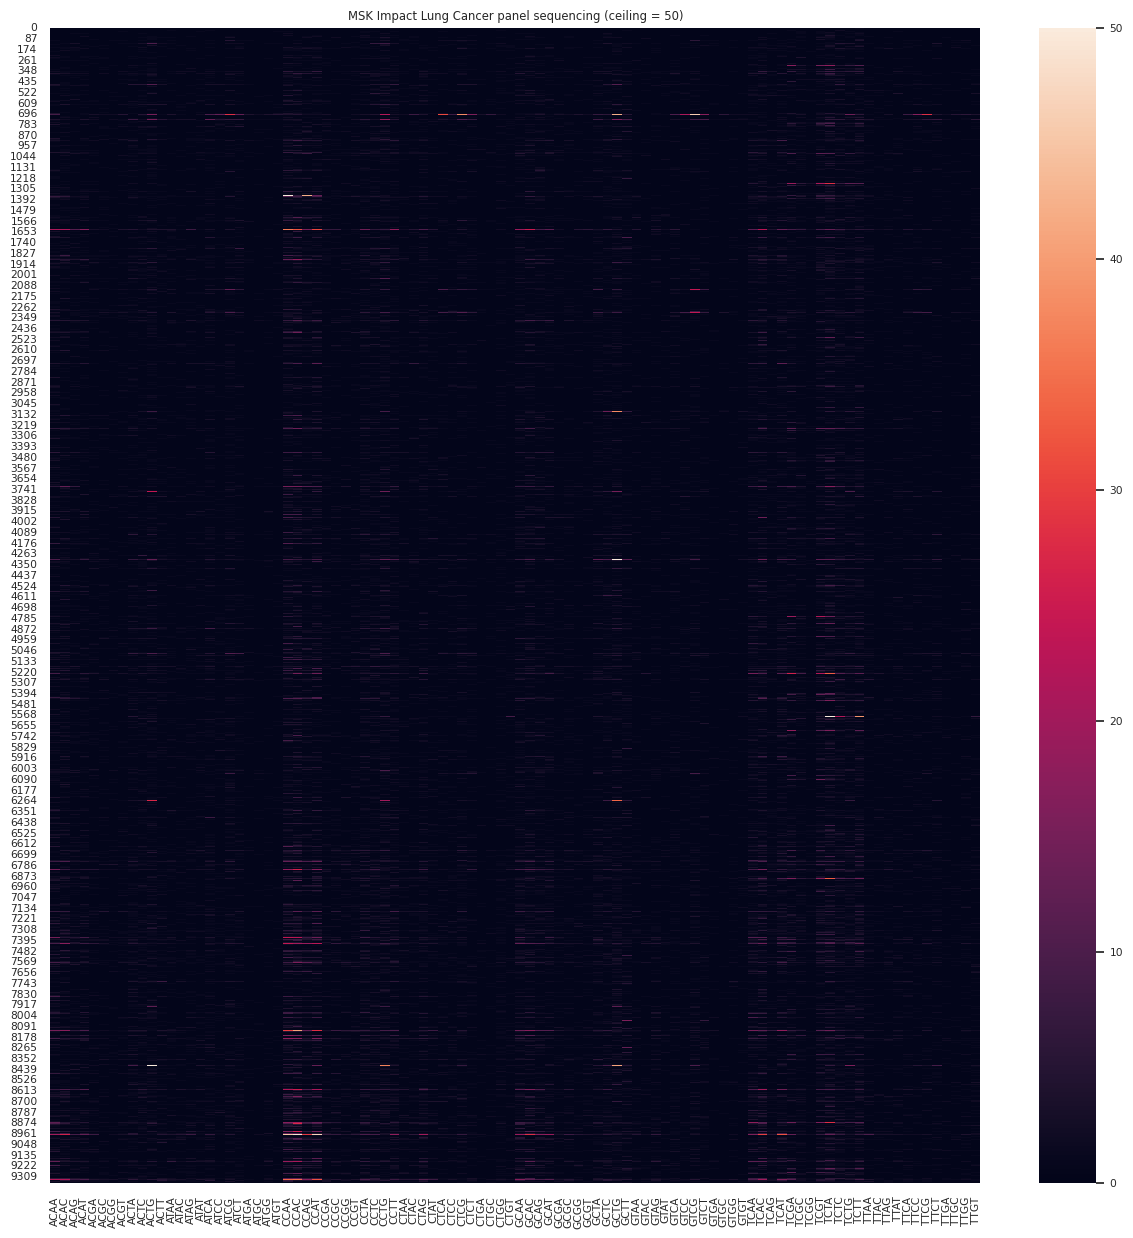

In [21]:
sns.set(font_scale=0.7)
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(mtx_impact,
                 vmax = 50,
                 xticklabels=unique_mut_impact,
                 )
ax.set_title('MSK Impact Lung Cancer panel sequencing (ceiling = 50)')
plt.show()

# suppressed to 30 to get any decent signal at all

## NMF: WES

(684, 3)
(3, 96)
0.21293897876948847


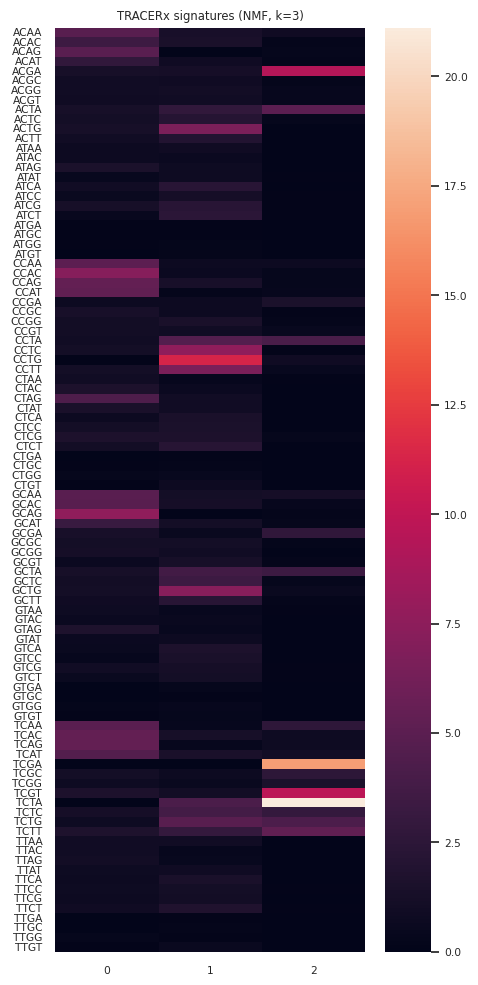

In [24]:
model_3 = NMF(n_components=3, init='random', random_state=0, max_iter=1000000)
W_3 = model_3.fit_transform(mtx_clean)
H_3 = model_3.components_

print(W_3.shape)
print(H_3.shape)
print(np.linalg.norm(mtx_clean - np.matmul(W_3, H_3)) / np.linalg.norm(mtx_clean))

sns.set(font_scale=0.7)
fig, ax = plt.subplots(figsize=(5,12))
ax = sns.heatmap(H_3.T,
                 yticklabels=unique_mut,
                 )
ax.set_title('TRACERx signatures (NMF, k=3)')
plt.show()

(684, 5)
(5, 96)
0.16652725919439346


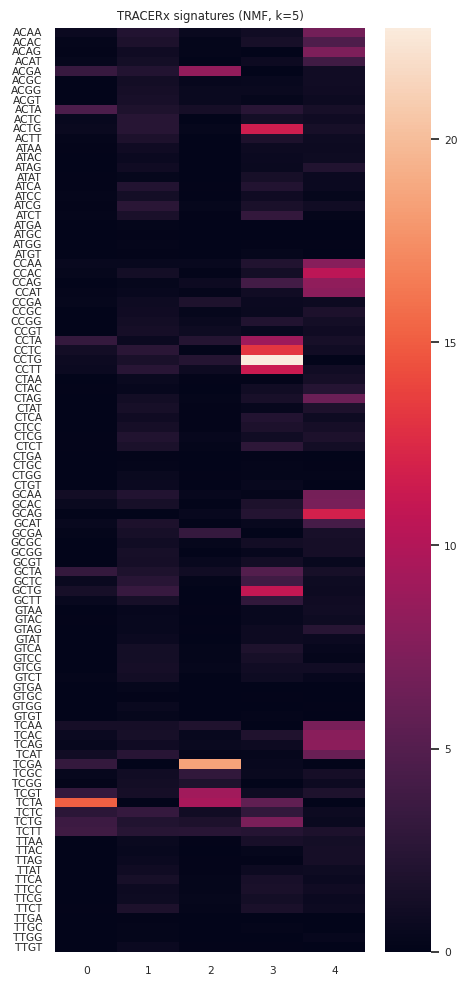

In [25]:
model_5 = NMF(n_components=5, init='random', random_state=0, max_iter=1000000)
W_5 = model_5.fit_transform(mtx_clean)
H_5 = model_5.components_

print(W_5.shape)
print(H_5.shape)
print(np.linalg.norm(mtx_clean - np.matmul(W_5, H_5)) / np.linalg.norm(mtx_clean))

sns.set(font_scale=0.7)
fig, ax = plt.subplots(figsize=(5,12))
ax = sns.heatmap(H_5.T,
                 yticklabels=unique_mut,
                 )
ax.set_title('TRACERx signatures (NMF, k=5)')
plt.show()

(684, 10)
(10, 96)


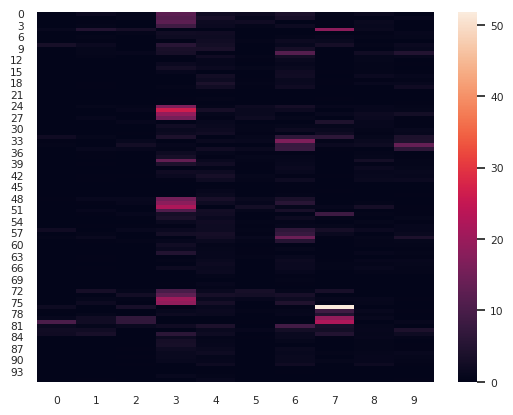

In [68]:
model_10 = NMF(n_components=10, init='random', random_state=0, max_iter=1000000)
W_10 = model_10.fit_transform(mtx_clean)
H_10 = model_10.components_

print(W_10.shape)
print(H_10.shape)

ax = sns.heatmap(H_10.T)
plt.show()

Increasing number of signatures improves the representation of the ground truth

# Comparison with COSMIC signatures

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

In [27]:
cosmic = pd.read_csv('../data/COSMIC_v3.4_SBS_GRCh37.txt', sep='\t', header=0)
cosmic['Type'] = cosmic['Type'].str.replace('[\[\]>]', '', regex=True)
cosmic.head()

# mutation order is same as the matrix, nice!

,Type,SBS1,SBS2,SBS3,SBS4,SBS5,SBS6,SBS7a,SBS7b,SBS7c,...,SBS90,SBS91,SBS92,SBS93,SBS94,SBS95,SBS96,SBS97,SBS98,SBS99
0,ACAA,0.000886,5.800000e-07,0.020808,0.042196,0.011998,0.000425,0.000067,0.002329,0.004830,...,0.002202,0.002945,0.011329,0.011573,0.015580,0.038408,0.011431,0.008159,0.008804,0.000004
1,ACAC,0.002280,1.480040e-04,0.016507,0.033297,0.009438,0.000524,0.000179,0.000461,0.001150,...,0.000708,0.052997,0.009745,0.008096,0.024746,0.017384,0.007771,0.007513,0.006769,0.000007
2,ACAG,0.000177,5.230000e-05,0.001751,0.015599,0.001850,0.000052,0.000071,0.000186,0.000377,...,0.000139,0.000204,0.004697,0.001761,0.001574,0.008360,0.001997,0.001375,0.032959,0.000051
3,ACAT,0.001280,9.780000e-05,0.012205,0.029498,0.006609,0.000180,0.000248,0.000710,0.001960,...,0.001755,0.000131,0.007758,0.008421,0.011076,0.023294,0.011809,0.006858,0.003758,0.000031
4,ACGA,0.001860,2.230000e-16,0.019708,0.006889,0.010098,0.000471,0.000065,0.000009,0.001120,...,0.000508,0.000243,0.003056,0.008857,0.007004,0.003617,0.009295,0.002347,0.006897,0.000446


In [28]:
artifacts = ['Type', 'SBS43', 'SBS45', 'SBS46', 'SBS47', 'SBS48', 'SBS49', 'SBS50','SBS51', 'SBS52', 'SBS53', 'SBS54', 'SBS55', 'SBS56', 'SBS57', 'SBS58','SBS59', 'SBS60', 'SBS95']

signatures = cosmic.drop(artifacts, axis=1)
signatures.columns

Index(['SBS1', 'SBS2', 'SBS3', 'SBS4', 'SBS5', 'SBS6', 'SBS7a', 'SBS7b',
       'SBS7c', 'SBS7d', 'SBS8', 'SBS9', 'SBS10a', 'SBS10b', 'SBS10c',
       'SBS10d', 'SBS11', 'SBS12', 'SBS13', 'SBS14', 'SBS15', 'SBS16',
       'SBS17a', 'SBS17b', 'SBS18', 'SBS19', 'SBS20', 'SBS21', 'SBS22a',
       'SBS22b', 'SBS23', 'SBS24', 'SBS25', 'SBS26', 'SBS27', 'SBS28', 'SBS29',
       'SBS30', 'SBS31', 'SBS32', 'SBS33', 'SBS34', 'SBS35', 'SBS36', 'SBS37',
       'SBS38', 'SBS39', 'SBS40a', 'SBS40b', 'SBS40c', 'SBS41', 'SBS42',
       'SBS44', 'SBS84', 'SBS85', 'SBS86', 'SBS87', 'SBS88', 'SBS89', 'SBS90',
       'SBS91', 'SBS92', 'SBS93', 'SBS94', 'SBS96', 'SBS97', 'SBS98', 'SBS99'],
      dtype='object')

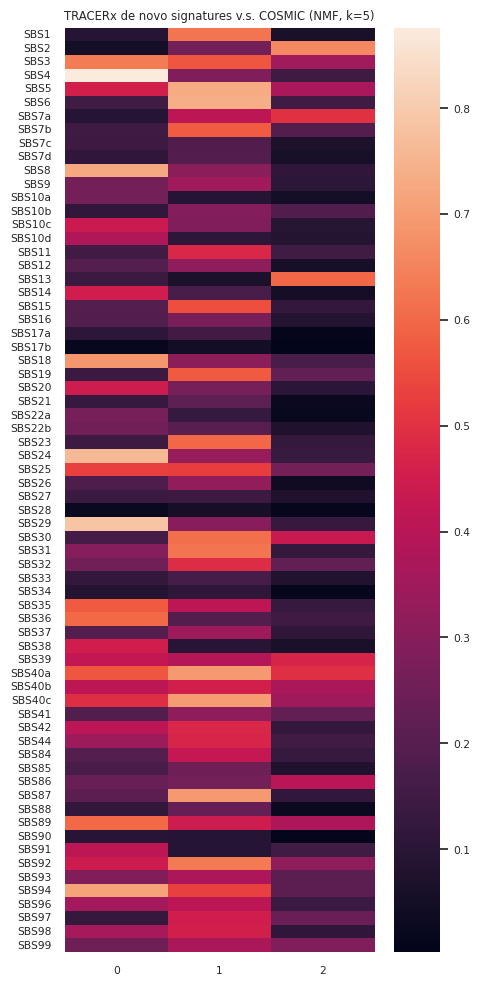

In [32]:
m,n = H_3.shape
similarity = np.zeros((m, signatures.shape[1]))

for i in range(m): 
    for j in range(signatures.shape[1]):
        similarity[i,j] = cosine_similarity(H_3[i,:].reshape(-1,1).T, 
                                            signatures.iloc[:,j].to_numpy().reshape(-1,1).T)[0,0]
fig,ax = plt.subplots(figsize=(5,12))
ax = sns.heatmap(similarity.T,
                 yticklabels=signatures.columns
                 )
ax.set_title('TRACERx de novo signatures v.s. COSMIC (NMF, k=5)')
plt.show()

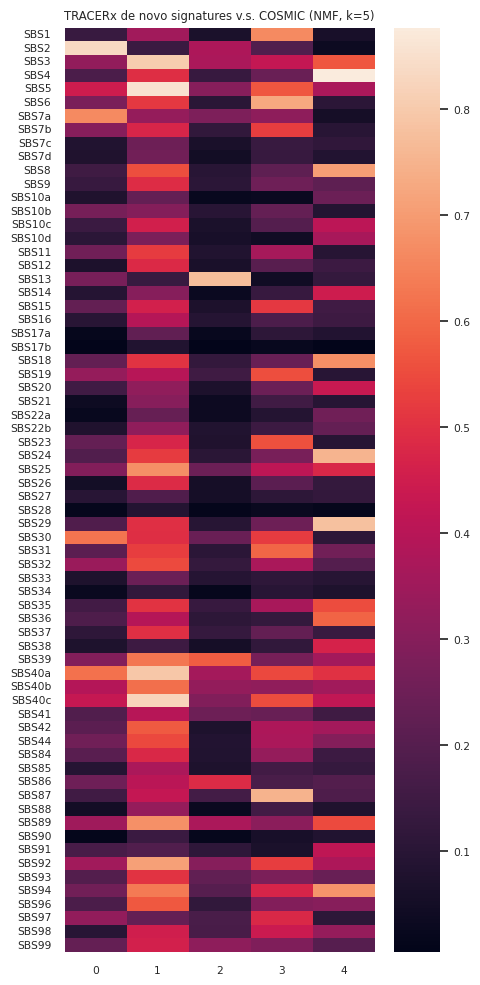

In [31]:
m,n = H_5.shape
similarity = np.zeros((m, signatures.shape[1]))

for i in range(m): 
    for j in range(signatures.shape[1]):
        similarity[i,j] = cosine_similarity(H_5[i,:].reshape(-1,1).T, 
                                            signatures.iloc[:,j].to_numpy().reshape(-1,1).T)[0,0]
fig,ax = plt.subplots(figsize=(5,12))
ax = sns.heatmap(similarity.T,
                 yticklabels=signatures.columns
                 )
ax.set_title('TRACERx de novo signatures v.s. COSMIC (NMF, k=5)')
plt.show()

# Signatures stratify histology or origin? No

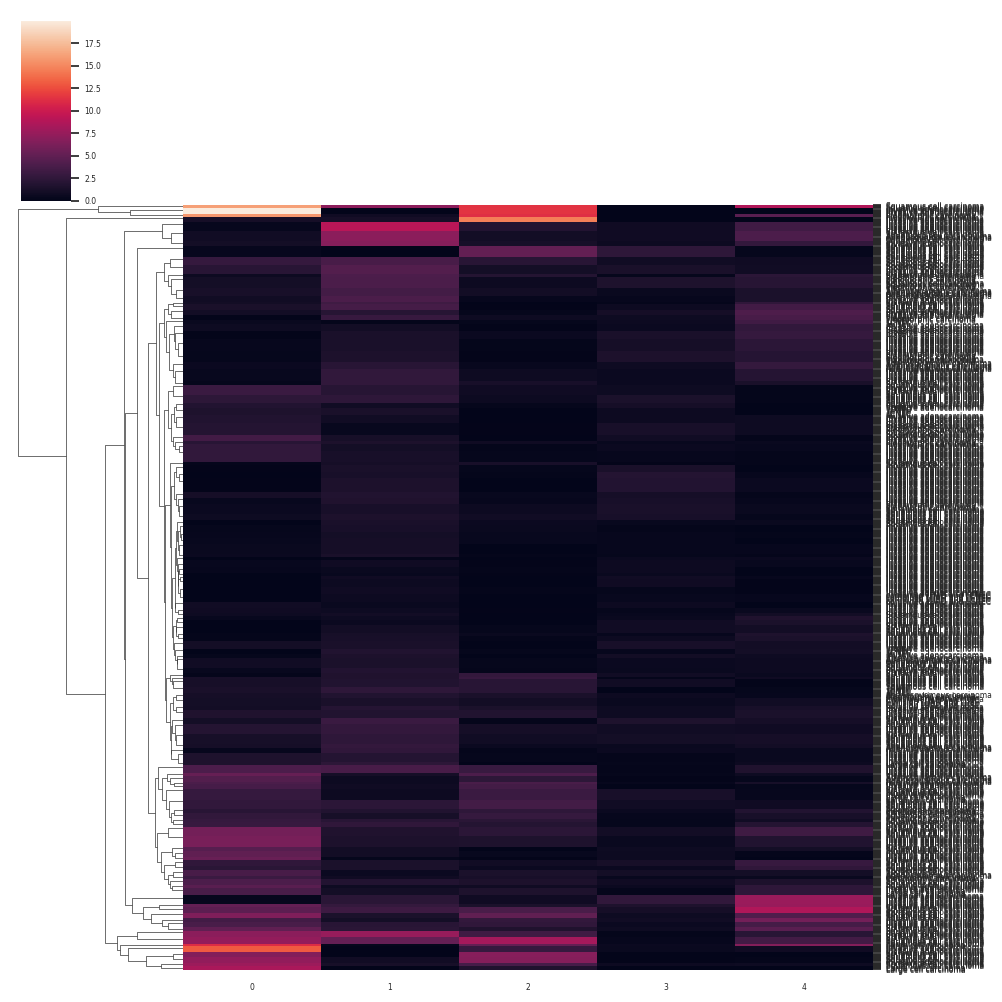

In [150]:
sns.set(font_scale=0.5)
ax = sns.clustermap(W_5,
                    col_cluster=False,
                    # z_score=0,
                    yticklabels=list(map_sample_hist.values()),
                    # figsize=(10,30),
)
plt.show()

### Fit panel sequencing

(9360, 5)


/lila/data/morrisq/huangf2/mambaforge/envs/sigtensor/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


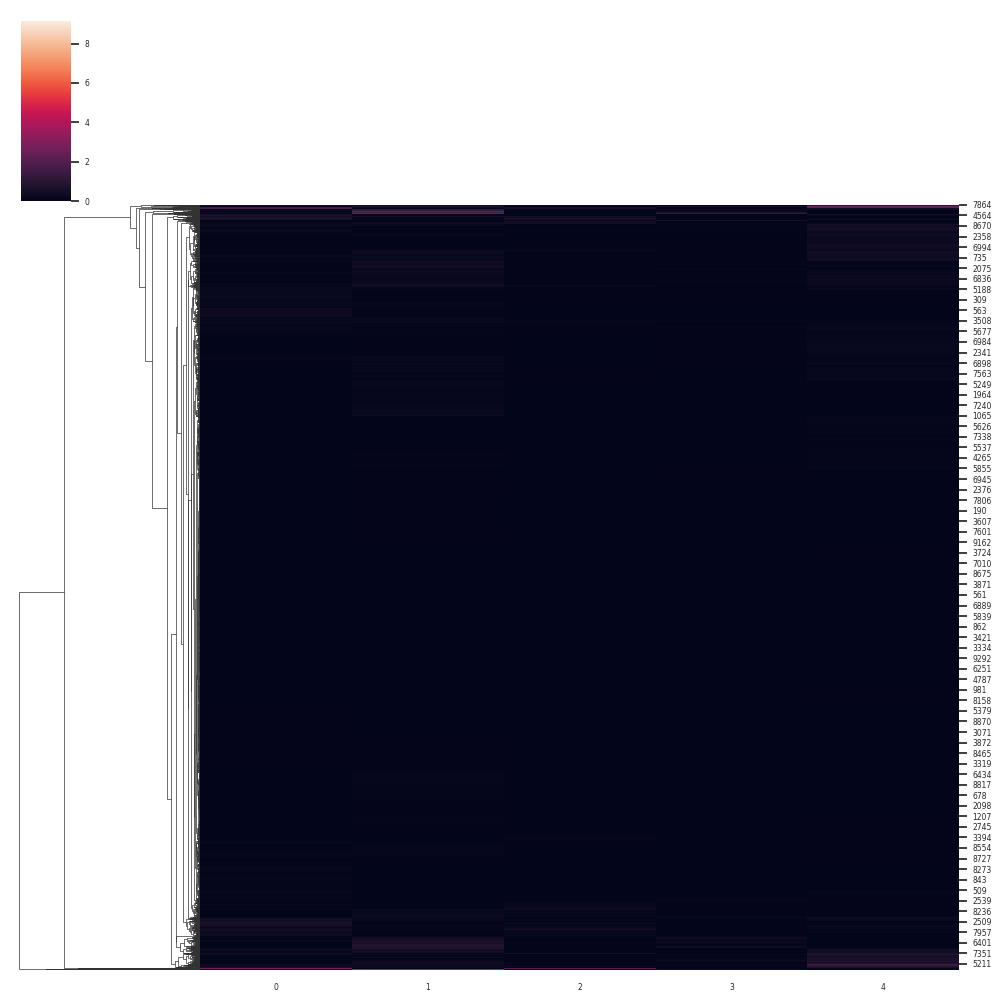

In [147]:
attribution = model_5.transform(mtx_impact)
print(attribution.shape)

ax = sns.clustermap(attribution,
                    col_cluster=False,
                    z_score=0,
                    # yticklabels=list(map_sample_hist.values()),
                    # figsize=(10,30),
)
plt.show()

signatures extracted from WES does a poor job at generalizing to subtypes in panel sequencing

# Tensor decomposition

In [33]:
from sklearn.decomposition import FactorAnalysis, PCA
import tensorly as tl
from tensorly.decomposition import parafac, non_negative_parafac, non_negative_parafac_hals

In [34]:
tensor_clean = np.delete(tensor, [275, 276, 277, 278, 279, 280], 0)
print(tensor_clean.shape)

sample_arr = np.delete(sample_arr, [275, 276, 277, 278, 279, 280], 0)
print(len(sample_arr))

(684, 96, 2867)
684


In [35]:
X = tensor_clean.copy()
rank = 5
factors = non_negative_parafac_hals(X, rank=rank, n_iter_max = 200, tol=1e-10)

In [49]:
X = tensor_clean.copy()
rank = 2
factors_2 = non_negative_parafac_hals(X, rank=rank, n_iter_max = 200, tol=1e-10)

In [36]:
X = tensor_clean.copy()
rank = 3
factors_3 = non_negative_parafac_hals(X, rank=rank, n_iter_max = 200, tol=1e-10)

In [37]:
rank = 10
factors_10 = non_negative_parafac_hals(X, rank=rank, n_iter_max = 500, tol=1e-10)

In [50]:
X_est = tl.cp_to_tensor(factors)
X_est_2 = tl.cp_to_tensor(factors_2)
X_est_3 = tl.cp_to_tensor(factors_3)
X_est_10 = tl.cp_to_tensor(factors_10)

print('Reconstruction error:')

# evaluate goodness of fit on 3D tensor
print('rank = 2:', tl.norm(X - X_est_2))
print('rank = 3:', tl.norm(X - X_est_3))
print('rank = 5:', tl.norm(X - X_est))
print('rank = 10:', tl.norm(X - X_est_10))

# compare to NMF on the collapsed 2D matrix
err_2d = tl.norm(np.sum(X, axis=2) - np.sum(X_est, axis=2)) / np.linalg.norm(np.sum(X, axis=2))
err_2d_2 = tl.norm(np.sum(X, axis=2) - np.sum(X_est_2, axis=2)) / np.linalg.norm(np.sum(X, axis=2))
err_2d_3 = tl.norm(np.sum(X, axis=2) - np.sum(X_est_3, axis=2)) / np.linalg.norm(np.sum(X, axis=2))
err_2d_10 = tl.norm(np.sum(X, axis=2) - np.sum(X_est_10, axis=2)) / np.linalg.norm(np.sum(X, axis=2))

Reconstruction error:
rank = 2: 776.7731998527559
rank = 3: 775.6444786429023
rank = 5: 773.9355971521221
rank = 10: 770.6787365044122


Text(0.5, 1.0, 'CP decomposition reconstruction error on collapsed 2D matrix')

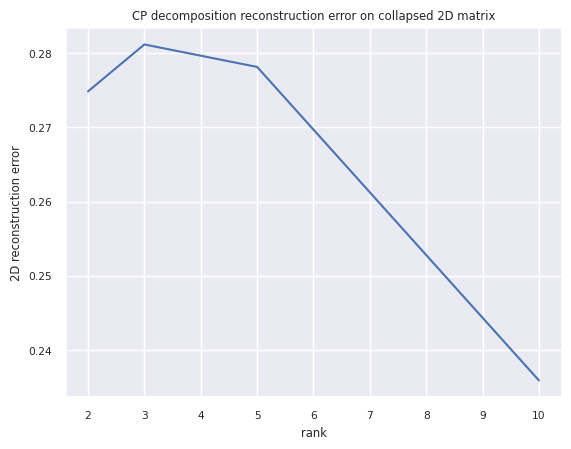

In [51]:
x = [2, 3, 5, 10]
y = [err_2d_2, err_2d_3, err_2d, err_2d_10]

plt.plot(x, y)
plt.xlabel('rank')
plt.ylabel('2D reconstruction error')
plt.title('CP decomposition reconstruction error on collapsed 2D matrix')

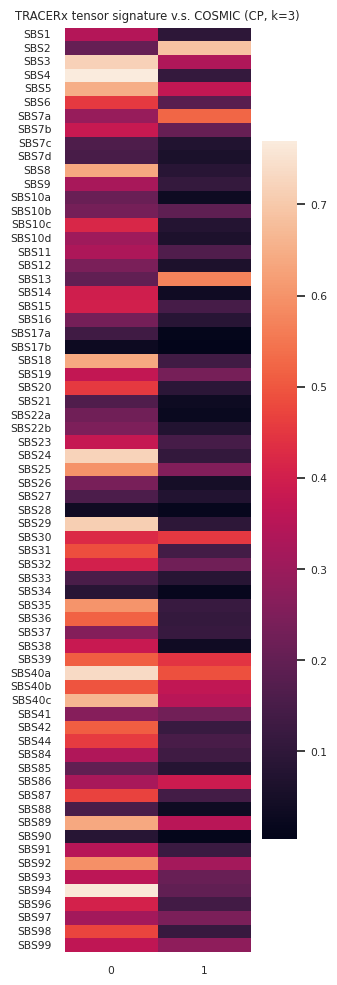

In [53]:
mut_to_sig = factors_2.factors[1].T
m,n = mut_to_sig.shape
similarity = np.zeros((m, signatures.shape[1]))

for i in range(m): 
    for j in range(signatures.shape[1]):
        similarity[i,j] = cosine_similarity(mut_to_sig[i,:].reshape(-1,1).T, 
                                            signatures.iloc[:,j].to_numpy().reshape(-1,1).T)[0,0]
        
fig,ax = plt.subplots(figsize=(3,12))
ax = sns.heatmap(similarity.T,
                 yticklabels=signatures.columns
                 )
ax.set_title('TRACERx tensor signature v.s. COSMIC (CP, k=3)')
plt.show()

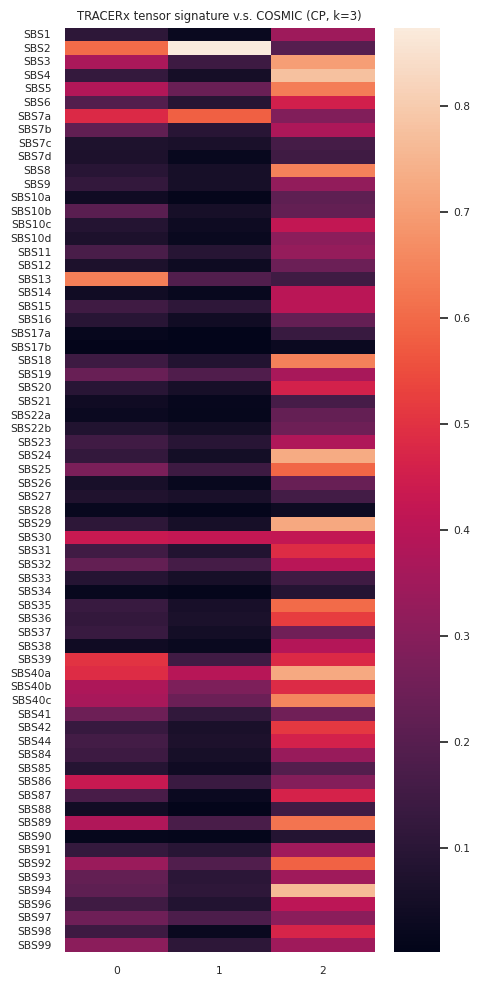

In [42]:
mut_to_sig = factors_3.factors[1].T
m,n = mut_to_sig.shape
similarity = np.zeros((m, signatures.shape[1]))

for i in range(m): 
    for j in range(signatures.shape[1]):
        similarity[i,j] = cosine_similarity(mut_to_sig[i,:].reshape(-1,1).T, 
                                            signatures.iloc[:,j].to_numpy().reshape(-1,1).T)[0,0]
        
fig,ax = plt.subplots(figsize=(5,12))
ax = sns.heatmap(similarity.T,
                 yticklabels=signatures.columns
                 )
ax.set_title('TRACERx tensor signature v.s. COSMIC (CP, k=3)')
plt.show()

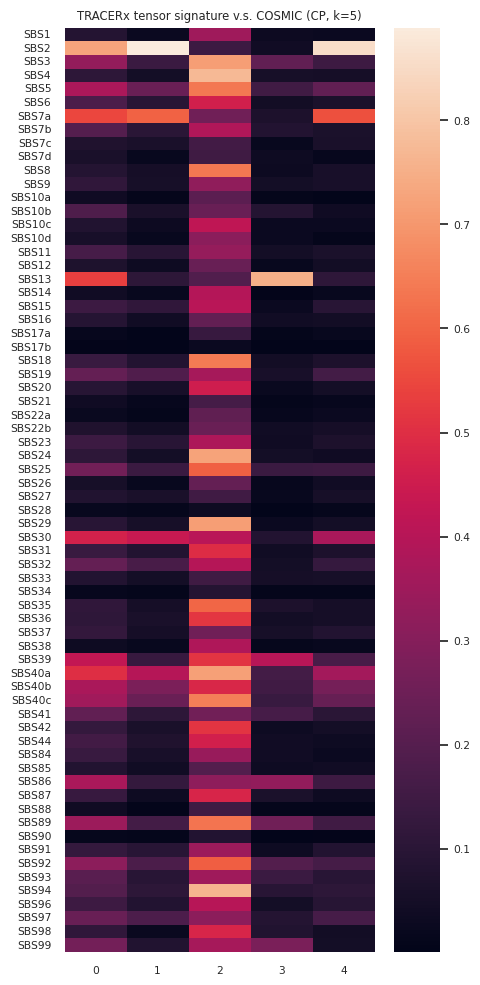

In [43]:
# compare to SBS signatures
mut_to_sig = factors.factors[1].T
m,n = mut_to_sig.shape
similarity = np.zeros((m, signatures.shape[1]))

for i in range(m): 
    for j in range(signatures.shape[1]):
        similarity[i,j] = cosine_similarity(mut_to_sig[i,:].reshape(-1,1).T, 
                                            signatures.iloc[:,j].to_numpy().reshape(-1,1).T)[0,0]
        
fig,ax = plt.subplots(figsize=(5,12))
ax = sns.heatmap(similarity.T,
                 yticklabels=signatures.columns
                 )
ax.set_title('TRACERx tensor signature v.s. COSMIC (CP, k=5)')
plt.show()

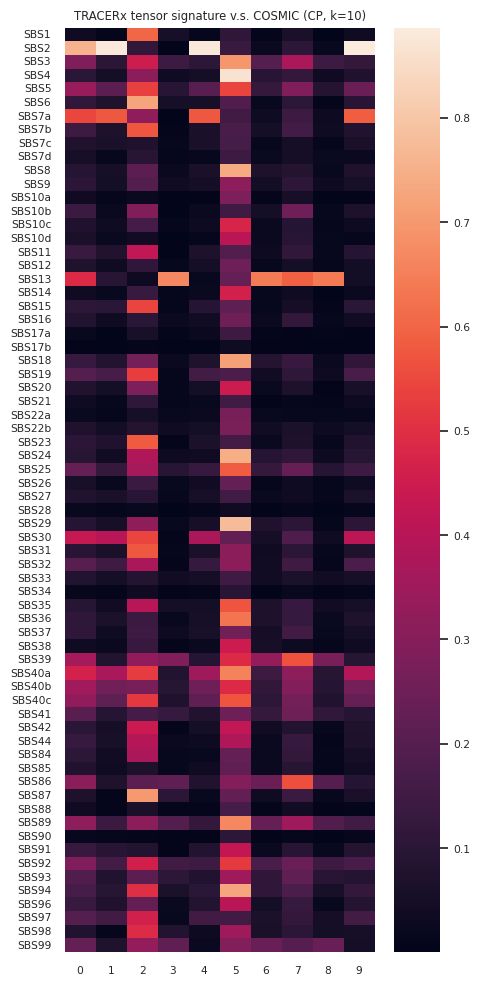

In [45]:
# compare to SBS signatures
mut_to_sig = factors_10.factors[1].T
m,n = mut_to_sig.shape
similarity = np.zeros((m, signatures.shape[1]))

for i in range(m): 
    for j in range(signatures.shape[1]):
        similarity[i,j] = cosine_similarity(mut_to_sig[i,:].reshape(-1,1).T, 
                                            signatures.iloc[:,j].to_numpy().reshape(-1,1).T)[0,0]
        
fig,ax = plt.subplots(figsize=(5,12))
ax = sns.heatmap(similarity.T,
                 yticklabels=signatures.columns
                 )
ax.set_title('TRACERx tensor signature v.s. COSMIC (CP, k=10)')
plt.show()

### PARAFAC algorithm comparison

In [71]:
X = tensor_clean.copy()
rank = 5
factors_nnparafac_hals = non_negative_parafac_hals(X, rank=rank, tol=1e-15)

In [41]:
X = tensor_clean.copy()
rank = 10
factors_nnparafac = non_negative_parafac(X, rank=rank)

In [73]:
X_parafac_hals = tl.cp_to_tensor(factors_nnparafac_hals)
X_parafac = tl.cp_to_tensor(factors_nnparafac)

print('Reconstruction error:')

# evaluate goodness of fit on 3D tensor
print('parafac_hals:', tl.norm(X - X_parafac_hals))
print('parafac:', tl.norm(X - X_parafac))

# compare to NMF on the collapsed 2D matrix
err_parafac_2d = tl.norm(np.sum(X, axis=2) - np.sum(X_parafac, axis=2)) / np.linalg.norm(np.sum(X, axis=2))
err_parafac_hals_2d = tl.norm(np.sum(X, axis=2) - np.sum(X_parafac_hals, axis=2)) / np.linalg.norm(np.sum(X, axis=2))

print('parafac_hals:', err_parafac_hals_2d)
print('parafac:', err_parafac_2d)

Reconstruction error:
rank = 5: 773.9377002259838
parafac_hals: 0.27732935280344156


In [48]:
rank = 10
factors_nnparafac_hals_10 = non_negative_parafac_hals(X, rank=rank)
factors_nnparafac_10 = non_negative_parafac(X, rank=rank)

X_parafac_hals_10 = tl.cp_to_tensor(factors_nnparafac_hals_10)
X_parafac_10 = tl.cp_to_tensor(factors_nnparafac_10)

print('Reconstruction error:')

# evaluate goodness of fit on 3D tensor
print('parafac_hals:', tl.norm(X - X_parafac_hals_10))
print('parafac:', tl.norm(X - X_parafac_10))

# compare to NMF on the collapsed 2D matrix
err_parafac_2d_10 = tl.norm(np.sum(X, axis=2) - np.sum(X_parafac_10, axis=2)) / np.linalg.norm(np.sum(X, axis=2))
err_parafac_hals_2d_10 = tl.norm(np.sum(X, axis=2) - np.sum(X_parafac_hals_10, axis=2)) / np.linalg.norm(np.sum(X, axis=2))

print('parafac_hals:', err_parafac_hals_2d_10)
print('parafac:', err_parafac_2d_10)

Reconstruction error:
parafac_hals: 773.155410097276
parafac: 774.5781625259278
parafac_hals: 0.19708379152648905
parafac: 0.20263147394797626


Hierarchical alternating least squared (HALS) optimization improves the runtime and reconstruction of CP tensor factorization. It is in fact shown that [HALS is a good default choice](https://tensorly.org/dev/auto_examples/decomposition/plot_nn_cp_hals.html#sphx-glr-auto-examples-decomposition-plot-nn-cp-hals-py)

Doubling the number of clusters produce a small improvement in explaining the training data, at the cost of 2x runtime

## Plot factors

In [46]:
def plot_factors(factors, d=3):
    rank = factors[0].shape[1]
    fig, axes = plt.subplots(rank, d, figsize=(30, int(rank * 4 + 1)))
    factors_name = ["Sample", "Tri-nucleotide context", "Position"] 
    factors_list = [sample_arr, mut_arr, bin_arr]
    for ind, (factor, axs) in enumerate(zip(factors, axes.T)):
        axs[-1].set_xlabel(factors_name[ind])
        for i, (f, ax) in enumerate(zip(factor.T, axs)):
            sns.despine(top=True, ax=ax)
            x = factors_list[ind]
            ax.bar(x, f, width=0.9, edgecolor='none')
            ax.grid(axis='x')
            # ax.set_xticklabels(x, rotation=90)
            axes[i, 0].set_ylabel("Factor " + str(i+1))
    # plt.xticks(rotation=90)
    fig.tight_layout()

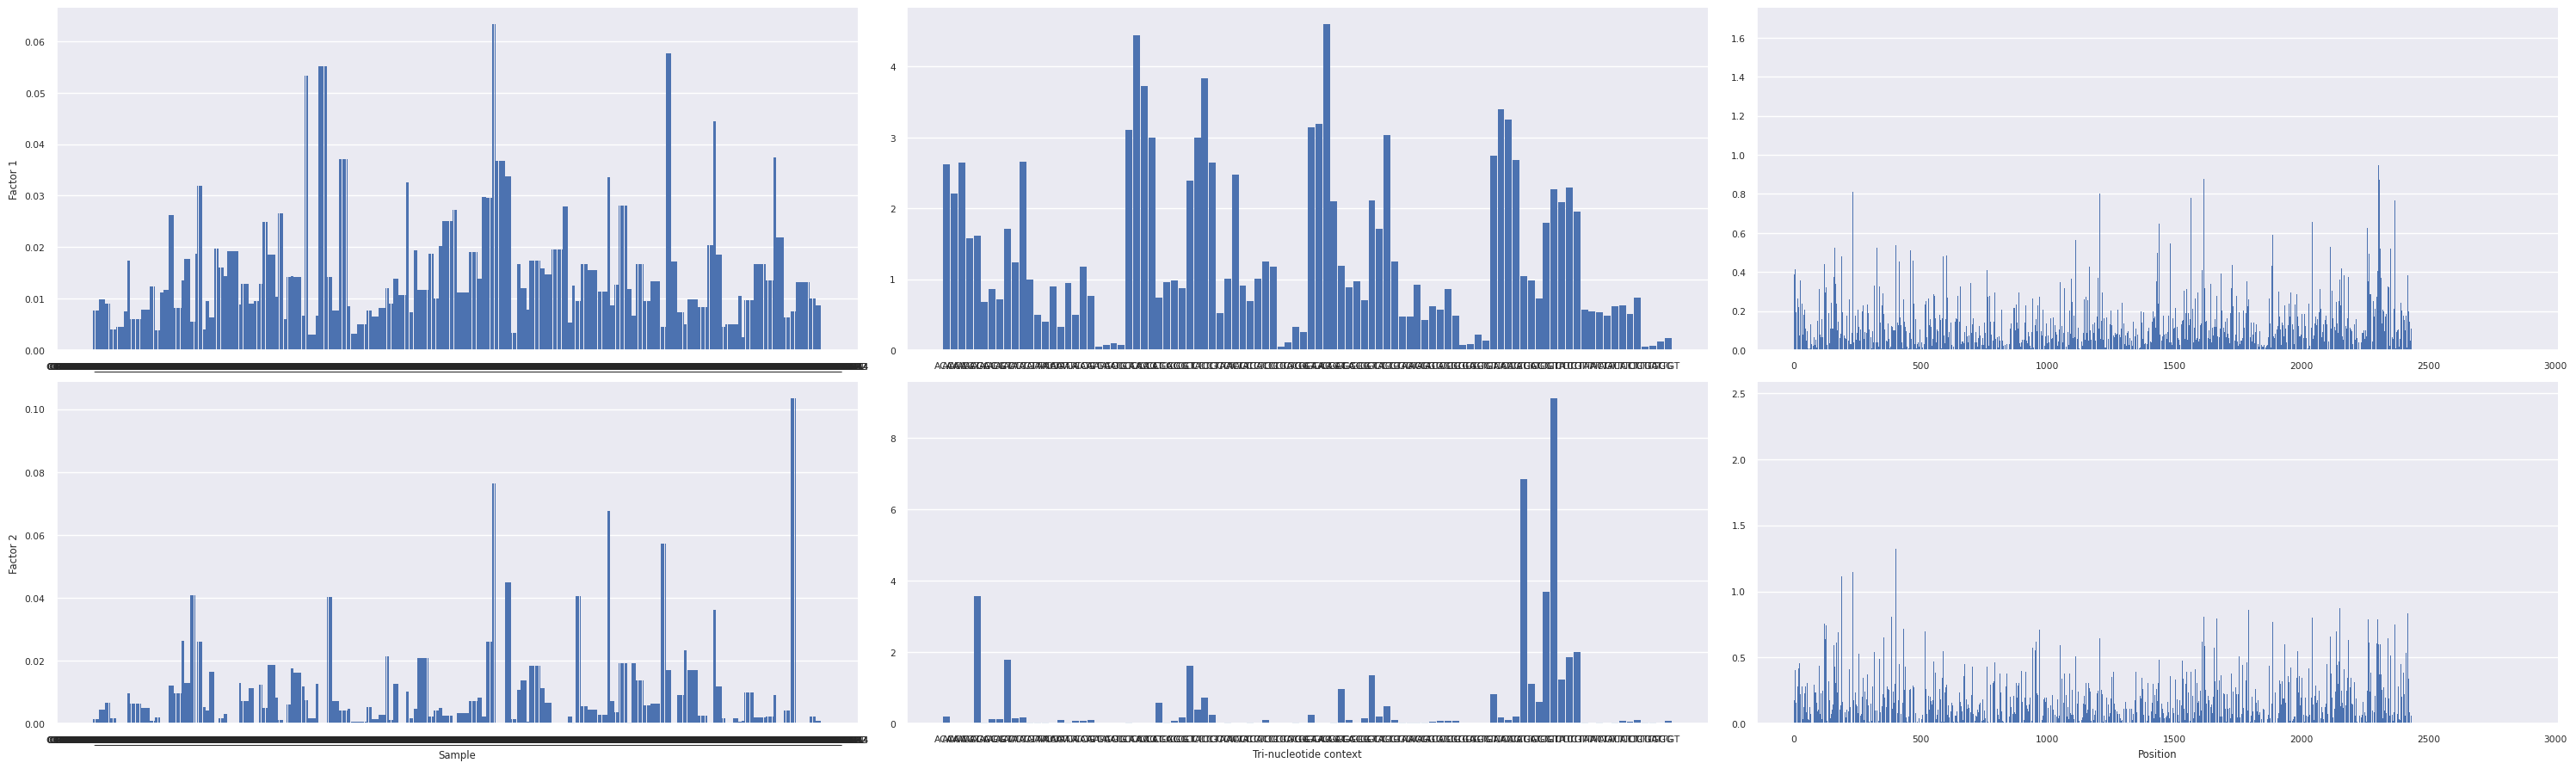

In [54]:
plot_factors(factors_2.factors)

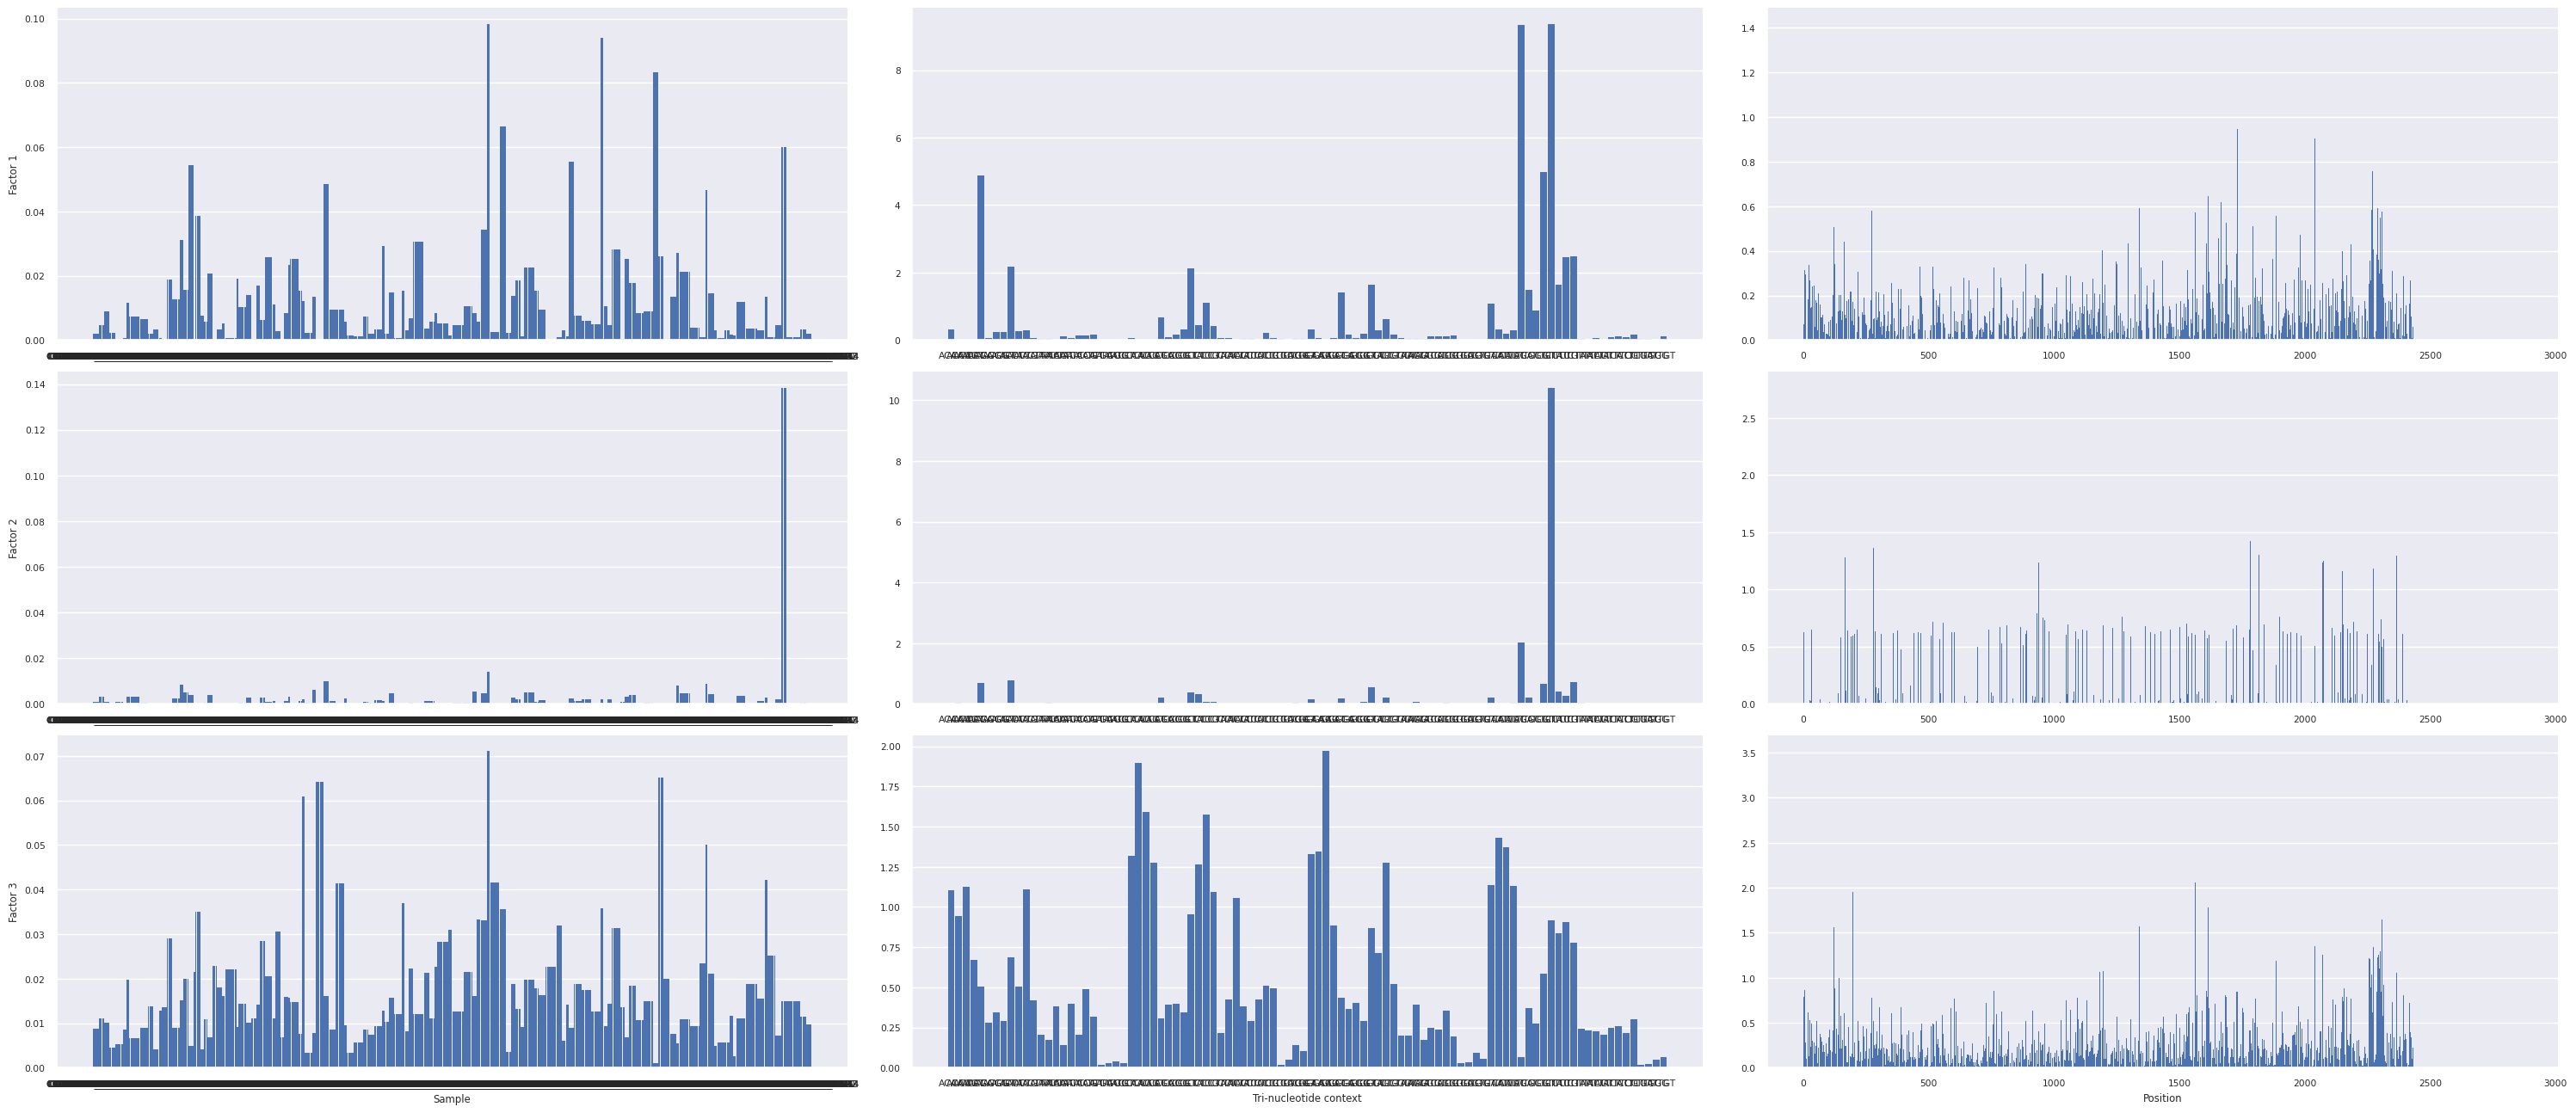

In [47]:
plot_factors(factors_3.factors)

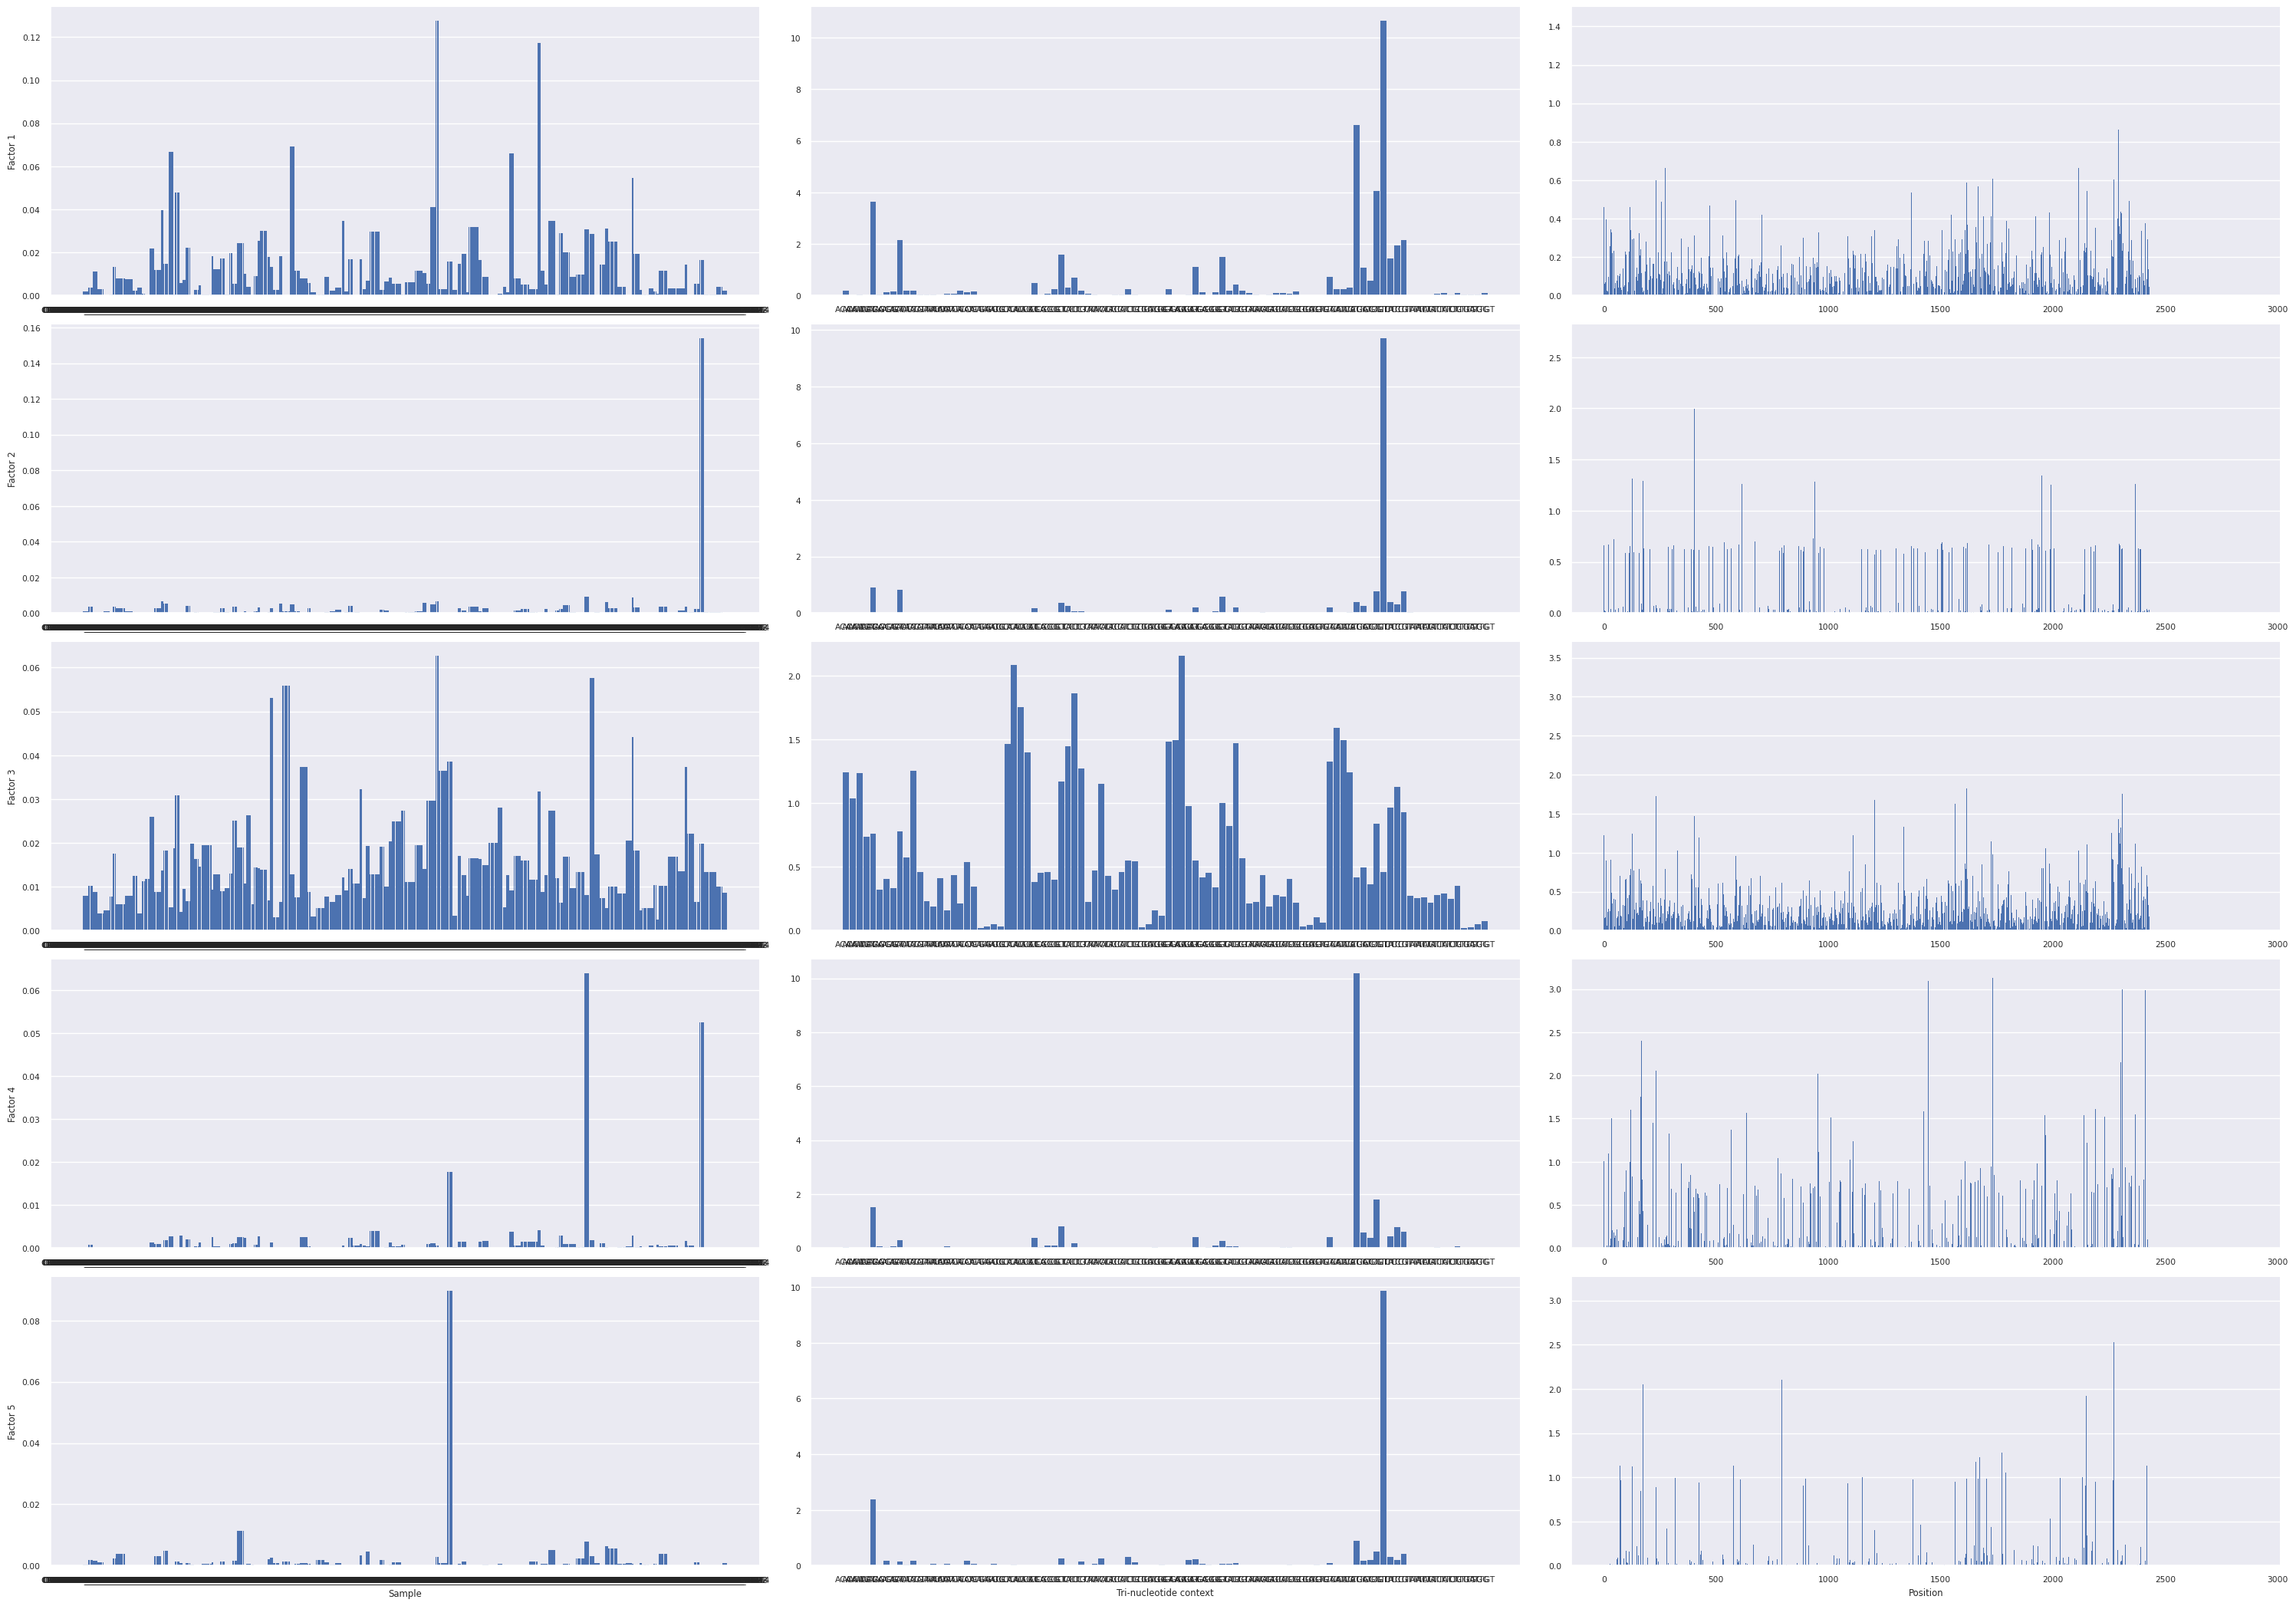

In [143]:
plot_factors(factors.factors)

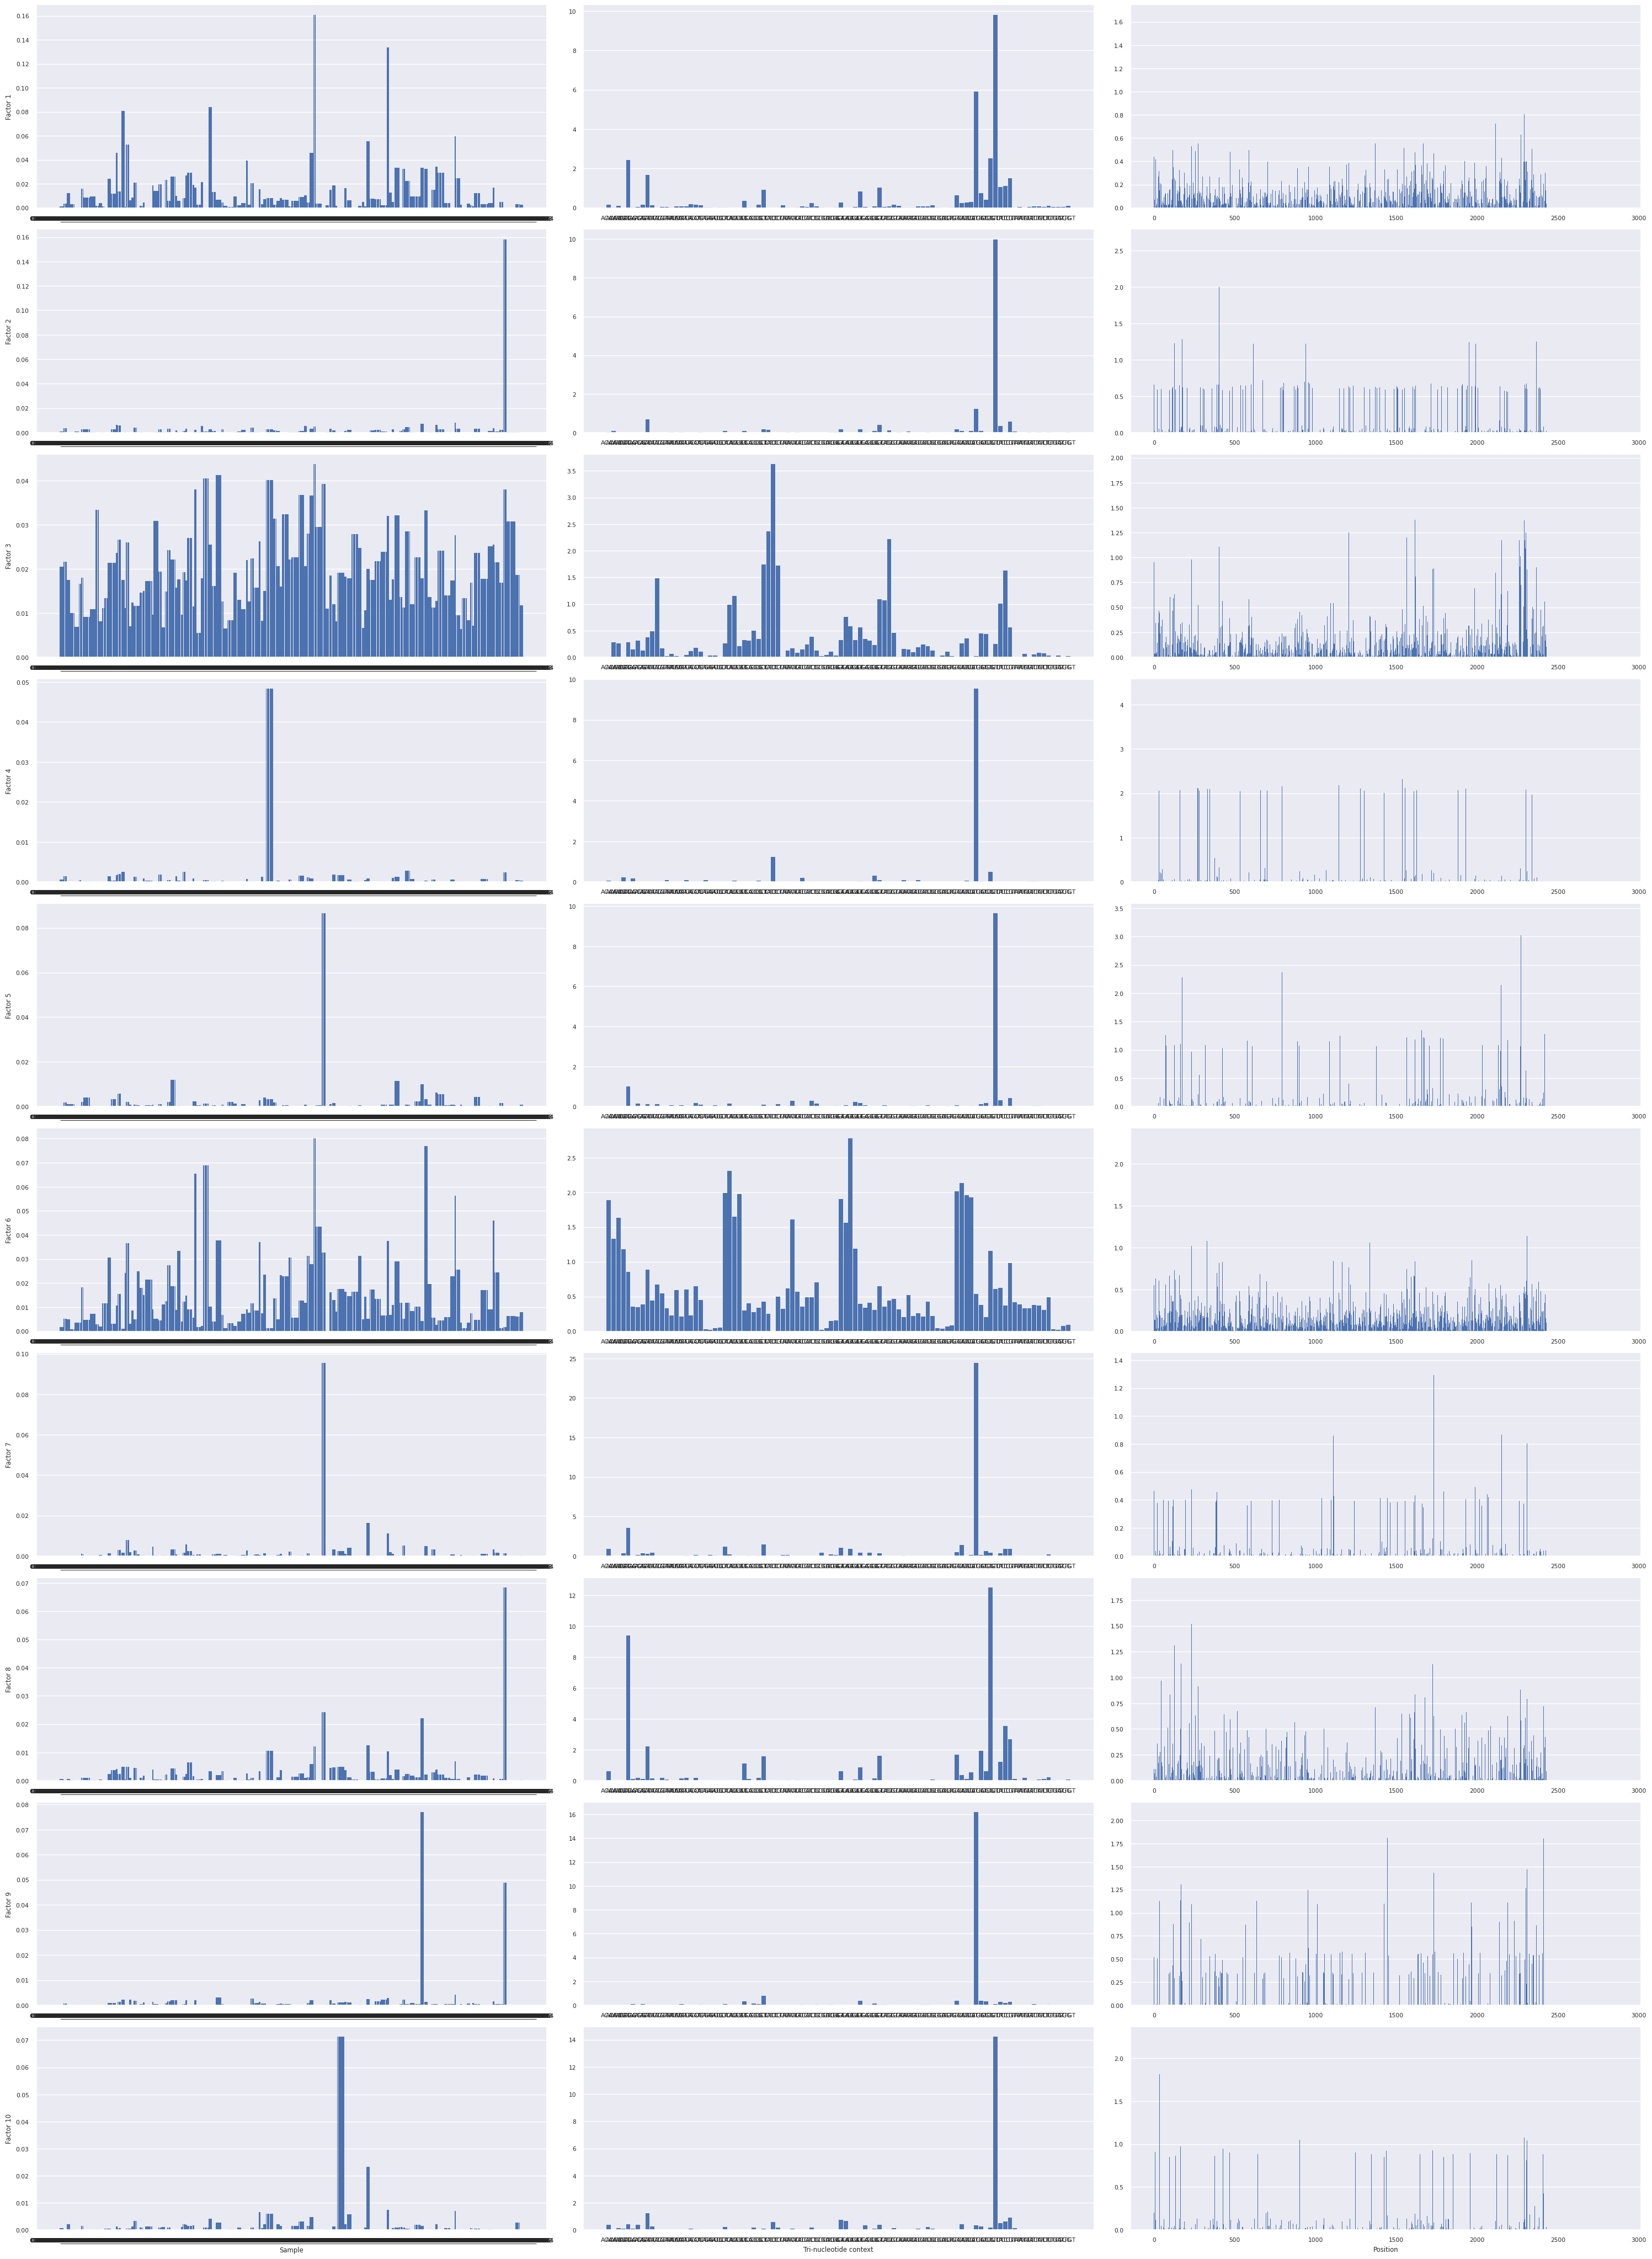

In [48]:
plot_factors(factors_10.factors)

### Tucker

# Fit tensor decomposition to IMPACT data

In [ ]:
# TODO

# Benchmark with SigProfiler

### Fitting COSMIC mutation signatures

In [2]:
from SigProfilerAssignment import Analyzer as Analyze

#### TRACERx

In [15]:
count_matrix = pd.crosstab(df['TRI_NT_CONTEXT'], df['SAMPLE'])

In [16]:
count_matrix.index = count_matrix.index.map(lambda x: re.sub(r'^(.{2})', r'\1>', x))
count_matrix

SAMPLE,CRUK0003_SU_FLN1,CRUK0003_SU_T1.R1,CRUK0003_SU_T1.R2,CRUK0003_SU_T1.R3,CRUK0003_SU_T1.R4,CRUK0003_SU_T1.R6,CRUK0004_BP_LN1,CRUK0004_SU_T1.R1,CRUK0004_SU_T1.R2,CRUK0004_SU_T1.R3,...,CRUK0817_SU_T1.R1,CRUK0817_SU_T1.R2,CRUK0817_SU_T1.R3,CRUK0817_SU_T1.R4,CRUK0817_SU_T1.R5,CRUK0872_SU_FLN1,CRUK0872_SU_T1.R1,CRUK0872_SU_T1.R2,CRUK0872_SU_T1.R3,CRUK0872_SU_T1.R4
TRI_NT_CONTEXT,,,,,,,,,,,,,,,,,,,,,
AC>AA,4,4,4,4,4,4,6,6,6,6,...,7,7,7,7,7,9,9,9,9,9
AC>AC,5,5,5,5,5,5,3,3,3,3,...,15,15,15,15,15,5,5,5,5,5
AC>AG,3,3,3,3,3,3,5,5,5,5,...,9,9,9,9,9,9,9,9,9,9
AC>AT,3,3,3,3,3,3,6,6,6,6,...,6,6,6,6,6,13,13,13,13,13
AC>GA,11,11,11,11,11,11,7,7,7,7,...,7,7,7,7,7,8,8,8,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TT>CT,7,7,7,7,7,7,5,5,5,5,...,5,5,5,5,5,7,7,7,7,7
TT>GA,0,0,0,0,0,0,2,2,2,2,...,1,1,1,1,1,1,1,1,1,1
TT>GC,1,1,1,1,1,1,0,0,0,0,...,3,3,3,3,3,0,0,0,0,0


In [17]:
Analyze.cosmic_fit(samples=count_matrix,
                   output="tracerx_mm",
                   input_type="matrix",
                   genome_build="GRCh37",
                   cosmic_version=3.3)

Assigning COSMIC sigs or Signature Database ...... 


|████████████████████████████████████████| 690/690 [100%] in 5:14.1 (2.20/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 


#### MSK IMPACT

In [25]:
count_matrix_impact = pd.crosstab(df_impact_nsclc['mutation'], df_impact_nsclc['id'])
count_matrix_impact.index = count_matrix_impact.index.map(lambda x: re.sub(r'^(.{2})', r'\1>', x))

In [27]:
Analyze.cosmic_fit(samples=count_matrix_impact,
                   output="impact_nsclc_mm",
                   input_type="matrix",
                   genome_build="GRCh37",
                   cosmic_version=3.3)

Assigning COSMIC sigs or Signature Database ...... 


|████████████████████████████████████████| 9379/9379 [100%] in 49:53.9 (3.13/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 


this took an hour...

### de novo extraction of signatures

Hi Feiayng,

i may not know how to code but at least I can write you a cute lil message:
You're doing amazing and i love you <3

Hehe code code code 
